# 1. 数据生成

In [1]:
import os
import jieba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec

%matplotlib inline

In [2]:
basic = os.getcwd().replace("/BiLSTM", "")
file_path = basic + "/Data/简体30954条_3分类.csv"
w2v_path = basic + '/Data/WordEmbedding/Word60.model'
stop_path = basic + "/Data/dict/stopwords.txt"
stopwords = set(open(stop_path, "r").read().split("\n"))
model = Word2Vec.load(w2v_path)
data = pd.read_csv(file_path)
data = data[data["polarity_human"].isin([-1.0, 1.0])]
data["polarity_human"] = data["polarity_human"].apply(lambda x: int((x + 1.0) / 2.0))
data = pd.concat((data[data["polarity_human"] == 0], 
                  data[data["polarity_human"] == 1].iloc[:3267, :]), axis=0).sample(3267 * 2, random_state=999)
data.head()

,polarity_human,content
744,1,通过一系列活动强化各部门的安全生产管理，重点抓好细节的管理。
30062,0,海外上市的网络游戏公司PE(市盈率)只有10倍左右，同样是中国概念网络企业，却普遍低于互联网...
19236,0,而同期上证指数下跌幅度仅为0.99%。
7238,0,(2)工艺技术风险导致长时间停车。
2672,1,受益于新药进展的江苏吴中；


In [3]:
def Createfeature(sentence):
    words = jieba.lcut(sentence)
    l = len(words)
    feature = np.zeros((TIME_STEP, INPUT_SIZE))
    for i in range(TIME_STEP):
        if i < l:
            word = words[i].lower()
            if (word not in stopwords) and (word in model):
                feature[i, :] = model[word]
    return feature

In [4]:
# Hyper Parameters
EPOCH = 10               # train the training data n times
BATCH_SIZE = 512
HIDDEN_SIZE = 32
TIME_STEP = 20         # rnn time step / image height
INPUT_SIZE = 60         # rnn input size / image width
LR = 0.1               # learning rate

In [5]:
X = np.zeros((len(data), TIME_STEP, INPUT_SIZE))
Y = data["polarity_human"].values
for j in range(len(data)):
    X[j, :, :] = Createfeature(data.iloc[j, 1])
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, train_size=0.8, random_state=100)
train_x.shape

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/3b/wnl918tx4kj0flqblcc2_7500000gn/T/jieba.cache
Loading model cost 0.785 seconds.
Prefix dict has been built succesfully.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(5227, 20, 60)

# 2. 模型训练

In [6]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset, TensorDataset

In [7]:
torch.manual_seed(999)    # reproducible

In [8]:
# Data Loader for easy mini-batch return in training
train_x, train_y = torch.from_numpy(train_x), torch.from_numpy(train_y)
valid_x, valid_y = torch.from_numpy(valid_x), torch.from_numpy(valid_y)
train_loader = torch.utils.data.DataLoader(dataset=TensorDataset(train_x, train_y), 
                                           batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BiRNN(nn.Module):
    
    def __init__(self, hidden_size=HIDDEN_SIZE, num_layers=3, num_classes=2):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(INPUT_SIZE, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [10]:
rnn = BiRNN()
print(rnn)

BiRNN(
  (lstm): LSTM(60, 32, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [11]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()

Epoch:  0 | train loss: 0.6910 | valid loss: 1.0968 | train accuracy: 0.5026 | valid accuracy: 0.4897
Epoch:  1 | train loss: 0.6725 | valid loss: 0.6630 | train accuracy: 0.6076 | valid accuracy: 0.6098
Epoch:  2 | train loss: 0.6342 | valid loss: 0.6104 | train accuracy: 0.7404 | valid accuracy: 0.7253
Epoch:  3 | train loss: 0.4552 | valid loss: 0.5013 | train accuracy: 0.7806 | valid accuracy: 0.7544
Epoch:  4 | train loss: 0.3950 | valid loss: 0.4525 | train accuracy: 0.8443 | valid accuracy: 0.8103
Epoch:  5 | train loss: 0.3421 | valid loss: 0.4325 | train accuracy: 0.8684 | valid accuracy: 0.8202
Epoch:  6 | train loss: 0.3704 | valid loss: 0.4483 | train accuracy: 0.8680 | valid accuracy: 0.8026
Epoch:  7 | train loss: 0.2800 | valid loss: 0.4193 | train accuracy: 0.8915 | valid accuracy: 0.8202
Epoch:  8 | train loss: 0.2958 | valid loss: 0.3940 | train accuracy: 0.9154 | valid accuracy: 0.8271
Epoch:  9 | train loss: 0.2756 | valid loss: 0.4272 | train accuracy: 0.9227 | val

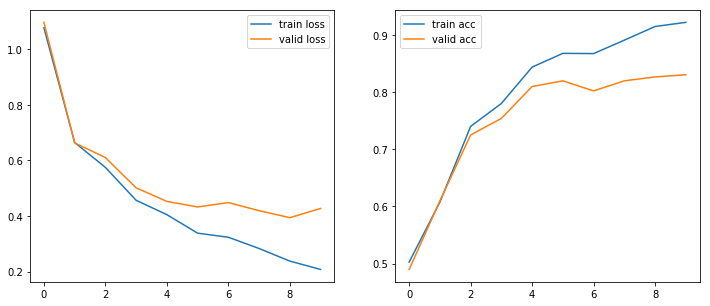

In [12]:
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.float())                       # batch x
        b_y = Variable(y.long())                        # batch y
        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 100 == 0:
            valid_output = rnn(Variable(valid_x.float()))
            train_output = rnn(Variable(train_x.float()))
            train_loss = loss_func(train_output, train_y.long())
            valid_loss = loss_func(valid_output, valid_y.long())
            train_losses.append(train_loss.data)
            valid_losses.append(valid_loss.data)
            
            pred_train = torch.max(train_output, 1)[1].data.numpy().squeeze()
            pred_valid = torch.max(valid_output, 1)[1].data.numpy().squeeze()
            train_accu = sum(pred_train == train_y.data.numpy()) / float(train_y.numpy().size)
            valid_accu = sum(pred_valid == valid_y.data.numpy()) / float(valid_y.numpy().size)
            train_accuracy.append(train_accu)
            valid_accuracy.append(valid_accu)
            
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| valid loss: %.4f' % valid_loss.data, 
                  '| train accuracy: %.4f' % train_accu, '| valid accuracy: %.4f' % valid_accu)

ax1.plot(train_losses, label="train loss")
ax1.plot(valid_losses, label="valid loss")
ax1.legend()
ax2.plot(train_accuracy, label="train acc")
ax2.plot(valid_accuracy, label="valid acc")
ax2.legend()

In [13]:
# print 10 predictions from test data
valid_output = rnn(Variable(valid_x.float()))
pred_y = torch.max(valid_output, 1)[1].data.numpy().squeeze()
pred_y[:10], valid_y[:10]

(array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1]), tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 1]))